# Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# XGBoost
import xgboost as xgb

# LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Hyperparameter tuning
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
import sys
import os

# Get project root one level up from current working directory (for Jupyter use)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add project root to Python path if not already included
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import constants from Streamlit app configuration
from app.config import FEATURES, TARGET, CUTOFF_DATE, FORECAST_END, HYPEROPT_SPACE

def main():
    print("Features:", FEATURES)
    print("Target:", TARGET)
    print("Cutoff Date:", CUTOFF_DATE)
    print("Forecast End:", FORECAST_END)
    print("Hyperopt Space:", HYPEROPT_SPACE)

if __name__ == "__main__":
    main()

# Import data

In [5]:
df_train = pd.read_csv('train_guayas_prepared.csv')

In [6]:
print(df_train.shape)
df_train.head()

(9437752, 12)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,0,GROCERY I,2013,1,2,2,NaN
1,24,96995,2013-01-03,NaN,0.0,0,GROCERY I,2013,1,3,3,NaN
2,24,96995,2013-01-04,NaN,0.0,0,GROCERY I,2013,1,4,4,NaN
3,24,96995,2013-01-05,NaN,0.0,0,GROCERY I,2013,1,5,5,NaN
4,24,96995,2013-01-06,NaN,0.0,0,GROCERY I,2013,1,6,6,NaN


In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,9437752.0,3.202915e+01,7.403736e+00,24.0,27.0,30.0,3.500000e+01,5.100000e+01
item_nbr,9437752.0,1.154137e+06,6.183704e+05,96995.0,627263.0,1136208.5,1.909409e+06,2.127114e+06
id,2747275.0,1.071884e+07,6.135138e+06,18790.0,5533892.0,10666113.0,1.588297e+07,2.165654e+07
unit_sales,9437752.0,2.070799e+00,8.254941e+00,0.0,0.0,0.0,1.000000e+00,2.935000e+03
onpromotion,9437752.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00
year,9437752.0,2.013198e+03,3.986724e-01,2013.0,2013.0,2013.0,2.013000e+03,2.014000e+03
month,9437752.0,5.640969e+00,3.592233e+00,1.0,2.0,5.0,9.000000e+00,1.200000e+01
day,9437752.0,1.571586e+01,8.762449e+00,1.0,8.0,16.0,2.300000e+01,3.100000e+01
day_of_week,9437752.0,3.004405e+00,1.999995e+00,0.0,1.0,3.0,5.000000e+00,6.000000e+00
unit_sales_7d_avg,9313024.0,2.067919e+00,6.849634e+00,0.0,0.0,0.0,1.571429e+00,5.035714e+02


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437752 entries, 0 to 9437751
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   date               object 
 3   id                 float64
 4   unit_sales         float64
 5   onpromotion        int64  
 6   family             object 
 7   year               int64  
 8   month              int64  
 9   day                int64  
 10  day_of_week        int64  
 11  unit_sales_7d_avg  float64
dtypes: float64(3), int64(7), object(2)
memory usage: 864.1+ MB


# Forecast

General preparation

In [7]:
# Ensure datetime and sort
df_train["date"] = pd.to_datetime(df_train["date"])
df_train = df_train.sort_values(["store_nbr", "item_nbr", "date"])

# Define forecast window
forecast_start = "2014-01-01"
forecast_end = "2014-03-31"
cutoff_date = "2013-12-31"
n_steps = len(pd.date_range(forecast_start, forecast_end))

# Group dataset by store and item
grouped = df_train[df_train["date"] <= forecast_end].groupby(["store_nbr", "item_nbr"])

# Feature set and target variable
features = ["onpromotion", "day", "month", "year"]
target = "unit_sales"

## XGBoost with default settings

In [18]:
# --- DATA PREPARATION ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import joblib

# Ensure datetime format
df_train["date"] = pd.to_datetime(df_train["date"])

# Filter 2013 data only
df_2013 = df_train[df_train["date"].dt.year == 2013]

# Group by store and item to compute statistics
stats = df_2013.groupby(["store_nbr", "item_nbr"]).agg(
    count_days=("unit_sales", "count"),
    mean_sales=("unit_sales", "mean"),
    std_sales=("unit_sales", "std"),
    positive_days=("unit_sales", lambda x: (x > 0).sum())
).reset_index()

# Filter only combinations with sufficient data
stats = stats[stats["count_days"] >= 300]

# Compute a custom score: mean / std
stats["score"] = stats["mean_sales"] / (stats["std_sales"] + 1e-5)

# Get the best combination
best_combo = stats.sort_values("score", ascending=False).iloc[0]
store_id = int(best_combo["store_nbr"])
item_id = int(best_combo["item_nbr"])

# Filter data for selected combination
print(f"Training model for store {store_id} and item {item_id}")
df = df_train[(df_train["store_nbr"] == store_id) & (df_train["item_nbr"] == item_id)].copy()
df = df.sort_values("date")

# Create lag and rolling features
df["lag_1"] = df["unit_sales"].shift(1)
df["lag_7"] = df["unit_sales"].shift(7)
df["rolling_mean_7"] = df["unit_sales"].shift(1).rolling(window=7).mean()

# Drop rows with missing lag features
df = df.dropna(subset=["lag_1", "lag_7", "rolling_mean_7"])

# Define features and target
features = [
    "onpromotion", "day", "month", "year", "day_of_week",
    "unit_sales_7d_avg", "lag_1", "lag_7", "rolling_mean_7"
]
target = "unit_sales"

# Define cutoff date for training/test split
cutoff_date = "2013-12-31"
df_train_split = df[df["date"] <= cutoff_date]
df_test_split = df[df["date"] > cutoff_date]

# Prepare training and test sets
X_train = df_train_split[features]
y_train = np.log1p(df_train_split[target])  # log-transform
X_test = df_test_split[features]
y_test = np.log1p(df_test_split[target])  # log-transform

# --- MODEL TRAINING AND TRACKING ---

# End any active MLflow run
if mlflow.active_run():
    mlflow.end_run()

# Set experiment
mlflow.set_experiment("store_item_sales_forecast")

with mlflow.start_run():
    # Train model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict and inverse-transform
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # Evaluate on inverse-transformed values
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    r2 = r2_score(np.expm1(y_test), y_pred)

    # Log metrics
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    # Log model with signature
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(
        model,
        "model",
        signature=signature,
        input_example=X_train.head(3)
    )

# Save model locally
joblib.dump(model, f"xgb_model_store{store_id}_item{item_id}.pkl")


Training model for store 24 and item 220435


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


['xgb_model_store24_item220435.pkl']

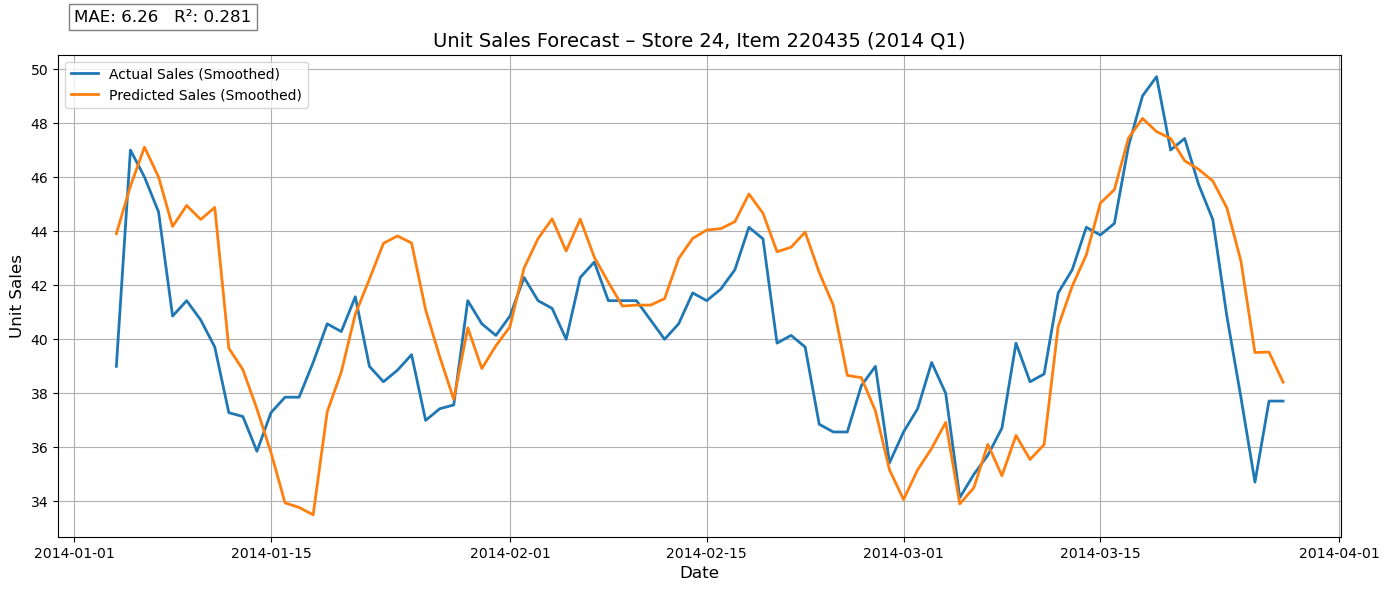

In [33]:
import matplotlib.pyplot as plt

# Copy test set and predictions
df_test_plot = df_test_split.copy()
df_test_plot["prediction"] = y_pred
df_test_plot["date"] = pd.to_datetime(df_test_plot["date"])

# Optional: smooth both series with rolling mean (7-day)
df_test_plot["actual_smooth"] = df_test_plot["unit_sales"].rolling(window=7, center=True).mean()
df_test_plot["pred_smooth"] = df_test_plot["prediction"].rolling(window=7, center=True).mean()

# Evaluate again for display (based on original)
mae_display = mean_absolute_error(df_test_plot["unit_sales"], df_test_plot["prediction"])
r2_display = r2_score(df_test_plot["unit_sales"], df_test_plot["prediction"])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_test_plot["date"], df_test_plot["actual_smooth"], label="Actual Sales (Smoothed)", linewidth=2)
plt.plot(df_test_plot["date"], df_test_plot["pred_smooth"], label="Predicted Sales (Smoothed)", linewidth=2)

# Titles and labels
plt.title(f"Unit Sales Forecast – Store {store_id}, Item {item_id} (2014 Q1)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Unit Sales", fontsize=12)
plt.legend()
plt.grid(True)

# Add MAE and R² to plot
textstr = f"MAE: {mae_display:.2f}   R²: {r2_display:.3f}"
plt.text(
    df_test_plot["date"].min(), 
    df_test_plot["unit_sales"].max() * 0.75,
    textstr,
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray')
)

plt.tight_layout()
plt.show()

## XGBoost with Hyperopt

In [23]:
# --- DATA PREPARATION ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import joblib
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Ensure datetime format
df_train["date"] = pd.to_datetime(df_train["date"])

# Filter 2013 data only
df_2013 = df_train[df_train["date"].dt.year == 2013]

# Group by store and item to compute statistics
stats = df_2013.groupby(["store_nbr", "item_nbr"]).agg(
    count_days=("unit_sales", "count"),
    mean_sales=("unit_sales", "mean"),
    std_sales=("unit_sales", "std"),
    positive_days=("unit_sales", lambda x: (x > 0).sum())
).reset_index()

# Filter only combinations with sufficient data
stats = stats[stats["count_days"] >= 300]

# Compute a custom score: mean / std
stats["score"] = stats["mean_sales"] / (stats["std_sales"] + 1e-5)

# Get the best combination
best_combo = stats.sort_values("score", ascending=False).iloc[0]
store_id = int(best_combo["store_nbr"])
item_id = int(best_combo["item_nbr"])

# Filter data for selected combination
print(f"Training model for store {store_id} and item {item_id}")
df = df_train[(df_train["store_nbr"] == store_id) & (df_train["item_nbr"] == item_id)].copy()
df = df.sort_values("date")

# Create lag and rolling features
df["lag_1"] = df["unit_sales"].shift(1)
df["lag_7"] = df["unit_sales"].shift(7)
df["rolling_mean_7"] = df["unit_sales"].shift(1).rolling(window=7).mean()

# Drop rows with missing lag features
df = df.dropna(subset=["lag_1", "lag_7", "rolling_mean_7"])

# Define features and target
features = [
    "onpromotion", "day", "month", "year", "day_of_week",
    "unit_sales_7d_avg", "lag_1", "lag_7", "rolling_mean_7"
]
target = "unit_sales"

# Define cutoff date for training/test split
cutoff_date = "2013-12-31"
df_train_split = df[df["date"] <= cutoff_date]
df_test_split = df[df["date"] > cutoff_date]

# Prepare training and test sets
X_train = df_train_split[features]
y_train = np.log1p(df_train_split[target])  # log-transform
X_test = df_test_split[features]
y_test = np.log1p(df_test_split[target])  # log-transform

# --- HYPEROPT XGBOOST TRAINING ---

# End any active MLflow run
if mlflow.active_run():
    mlflow.end_run()

mlflow.set_experiment("store_item_sales_forecast_hyperopt")

# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# Objective function for Hyperopt
def objective(params):
    model = xgb.XGBRegressor(random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = np.expm1(model.predict(X_test))
    score = mean_absolute_error(np.expm1(y_test), y_pred)
    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

# Retrieve best model
best_model = trials.best_trial['result']['model']
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate final model
mae = mean_absolute_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

with mlflow.start_run():
    mlflow.log_params(best)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    signature = infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(
        best_model,
        "model",
        signature=signature,
        input_example=X_train.head(3)
    )

# Save final model
joblib.dump(best_model, f"xgb_hyperopt_store{store_id}_item{item_id}.pkl")


Training model for store 24 and item 220435
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001111 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:02,  8.53trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 6.665895


  8%|▊         | 2/25 [00:00<00:02,  8.42trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000697 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 6.665895


 12%|█▏        | 3/25 [00:00<00:03,  6.54trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 6.665895


 16%|█▌        | 4/25 [00:00<00:02,  7.08trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 6.665895


 20%|██        | 5/25 [00:00<00:02,  7.59trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 6.665895
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 6.665895


 28%|██▊       | 7/25 [00:00<00:02,  8.97trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 6.665895


 32%|███▏      | 8/25 [00:01<00:02,  8.14trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 6.665895
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000702 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 6.665895


 40%|████      | 10/25 [00:01<00:01, 10.78trial/s, best loss: 6.665894646114773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 6.665895
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000723 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 6.665895


 48%|████▊     | 12/25 [00:01<00:01, 12.47trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000786 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 6.255276
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 6.255276


 56%|█████▌    | 14/25 [00:01<00:00, 11.63trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001518 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 6.255276
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 6.255276


 64%|██████▍   | 16/25 [00:01<00:00, 12.19trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000689 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 6.255276
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 6.255276


 72%|███████▏  | 18/25 [00:01<00:00, 11.45trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001044 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 6.255276
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000749 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 6.255276


 80%|████████  | 20/25 [00:01<00:00, 13.02trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001151 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 6.255276
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 6.255276


 88%|████████▊ | 22/25 [00:02<00:00, 11.16trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000761 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 6.255276
INFO:hyperopt.tpe:build_posterior_wrapper took 0.000732 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 6.255276


 96%|█████████▌| 24/25 [00:02<00:00, 11.88trial/s, best loss: 6.255276362101237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 6.255276


100%|██████████| 25/25 [00:02<00:00, 10.73trial/s, best loss: 6.255276362101237]

/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


['xgb_hyperopt_store24_item220435.pkl']

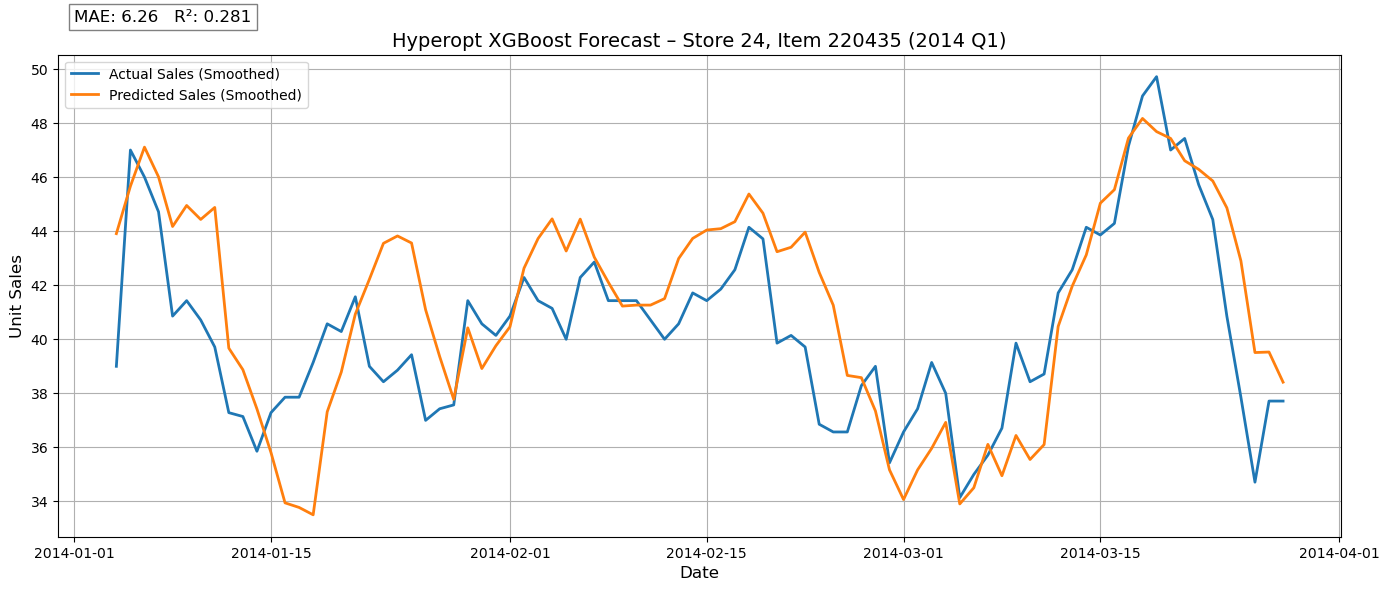

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Prepare test DataFrame
df_test_plot = df_test_split.copy()
df_test_plot["prediction"] = y_pred
df_test_plot["date"] = pd.to_datetime(df_test_plot["date"])

# Smooth both actual and predicted values
df_test_plot["actual_smooth"] = df_test_plot["unit_sales"].rolling(window=7, center=True).mean()
df_test_plot["pred_smooth"] = df_test_plot["prediction"].rolling(window=7, center=True).mean()

# Recalculate metrics (based on original scale)
mae_display = mean_absolute_error(df_test_plot["unit_sales"], df_test_plot["prediction"])
r2_display = r2_score(df_test_plot["unit_sales"], df_test_plot["prediction"])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_test_plot["date"], df_test_plot["actual_smooth"], label="Actual Sales (Smoothed)", linewidth=2)
plt.plot(df_test_plot["date"], df_test_plot["pred_smooth"], label="Predicted Sales (Smoothed)", linewidth=2)
plt.title(f"Hyperopt XGBoost Forecast – Store {store_id}, Item {item_id} (2014 Q1)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Unit Sales", fontsize=12)
plt.legend()
plt.grid(True)

# Display MAE and R²
textstr = f"MAE: {mae_display:.2f}   R²: {r2_display:.3f}"
plt.text(
    df_test_plot["date"].min(),
    df_test_plot["unit_sales"].max() * 0.75,
    textstr,
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='gray')
)

plt.tight_layout()
plt.show()

## LSTM

In [ ]:
# --- LSTM SALES FORECASTING ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import mlflow
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from mlflow.models.signature import infer_signature

# Prepare data
df_train["date"] = pd.to_datetime(df_train["date"])
df_train = df_train[df_train["unit_sales"] >= 0]
cutoff_date = pd.to_datetime("2013-12-31")

# Select one stable store-item combo
grouped = df_train.groupby(["store_nbr", "item_nbr"])
stats = grouped.size().reset_index(name="count")
valid_combos = stats[stats["count"] >= 300].sort_values("count", ascending=False)
store_id, item_id = valid_combos.iloc[0]["store_nbr"], valid_combos.iloc[0]["item_nbr"]

# Filter data
df = df_train[(df_train["store_nbr"] == store_id) & (df_train["item_nbr"] == item_id)].copy()
df = df.sort_values("date")

# Feature engineering
df = df.set_index("date")
df = df[["unit_sales"]].copy()
df["unit_sales"] = df["unit_sales"].astype(float)

# Normalize
scaler = MinMaxScaler()
df["unit_sales_scaled"] = scaler.fit_transform(df[["unit_sales"]])

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 14  # two-week window
series = df["unit_sales_scaled"].values
X, y = create_sequences(series, n_steps)

# Get cutoff using shifted index
dates = df.index[n_steps:]
split_point = np.sum(dates <= cutoff_date)

# Train/test split
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Define LSTM model with Input layer
model = Sequential()
model.add(Input(shape=(n_steps, 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# MLflow tracking
if mlflow.active_run():
    mlflow.end_run()
mlflow.set_experiment("lstm_unit_sales_forecast")

with mlflow.start_run():
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, validation_split=0.1)

    y_pred = model.predict(X_test, verbose=0)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    # Provide signature and input example as DataFrame
    input_example = pd.DataFrame(X_train[:3].reshape((3, -1)))
    signature = infer_signature(X_train[:3], model.predict(X_train[:3]))

    mlflow.keras.log_model(
        model,
        "lstm_model",
        signature=signature
    )

    print(f"✅ LSTM model trained | MAE: {mae:.2f}, R²: {r2:.3f}")

# Save model and scaler (new format)
model.save(f"lstm_model_store{store_id}_item{item_id}.keras")
joblib.dump(scaler, f"scaler_store{store_id}_item{item_id}.pkl")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
✅ LSTM model trained | MAE: 0.46, R²: 0.011


['scaler_store24_item96995.pkl']

In [45]:
# --- SEQ2SEQ LSTM FOR MULTI-STEP FORECASTING (WITH RELU + NON-NEGATIVE OUTPUT) ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import mlflow
import mlflow.keras
import joblib

# Parameters
n_input = 14   # input sequence length
n_output = 14  # forecast horizon

# Prepare data
subset = df_train[(df_train["store_nbr"] == store_id) & (df_train["item_nbr"] == item_id)].copy()
subset = subset.sort_values("date")
subset = subset[subset["unit_sales"] >= 0].copy()
subset = subset.set_index("date")
subset = subset[["unit_sales"]]

scaler = MinMaxScaler()
subset["scaled"] = scaler.fit_transform(subset[["unit_sales"]])

# Create sequences
def make_seq2seq_data(series, n_input, n_output):
    X, y = [], []
    for i in range(len(series) - n_input - n_output):
        X.append(series[i:i+n_input])
        y.append(series[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y)

series = subset["scaled"].values
X, y = make_seq2seq_data(series, n_input, n_output)

# Train/test split
dates = subset.index[n_input + n_output:]
cutoff = pd.to_datetime("2013-12-31")
split_idx = np.sum(dates <= cutoff)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Build Seq2Seq model
def build_seq2seq_model(n_input, n_output):
    encoder_inputs = Input(shape=(n_input, 1))
    encoder_lstm = LSTM(64, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(n_output, 1))
    decoder_lstm = LSTM(64, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='relu')  # ensure non-negative outputs
    outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='mae')
    return model

# Training decoder inputs
decoder_input_train = np.zeros((X_train.shape[0], n_output, 1))
decoder_input_test = np.zeros((X_test.shape[0], n_output, 1))

# Train model
model = build_seq2seq_model(n_input, n_output)
if mlflow.active_run(): mlflow.end_run()
mlflow.set_experiment("lstm_seq2seq_forecast")

with mlflow.start_run():
    model.fit([X_train, decoder_input_train], y_train[..., np.newaxis],
              epochs=30, batch_size=32, verbose=0, validation_split=0.1)

    y_pred = model.predict([X_test, decoder_input_test], verbose=0)
    y_pred = np.maximum(y_pred, 0)  # enforce non-negativity

    y_pred_inv = scaler.inverse_transform(y_pred[:, :, 0])
    y_test_inv = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)
    mlflow.keras.log_model(model, "lstm_seq2seq_model")
    print(f"✅ Seq2Seq LSTM trained | MAE: {mae:.2f}, R²: {r2:.3f}")

# Save model and scaler
model.save(f"lstm_seq2seq_store{store_id}_item{item_id}.keras")
joblib.dump(scaler, f"scaler_seq2seq_store{store_id}_item{item_id}.pkl")

2025/05/16 10:59:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/16 10:59:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Seq2Seq LSTM trained | MAE: 0.73, R²: 0.021


['scaler_seq2seq_store24_item96995.pkl']

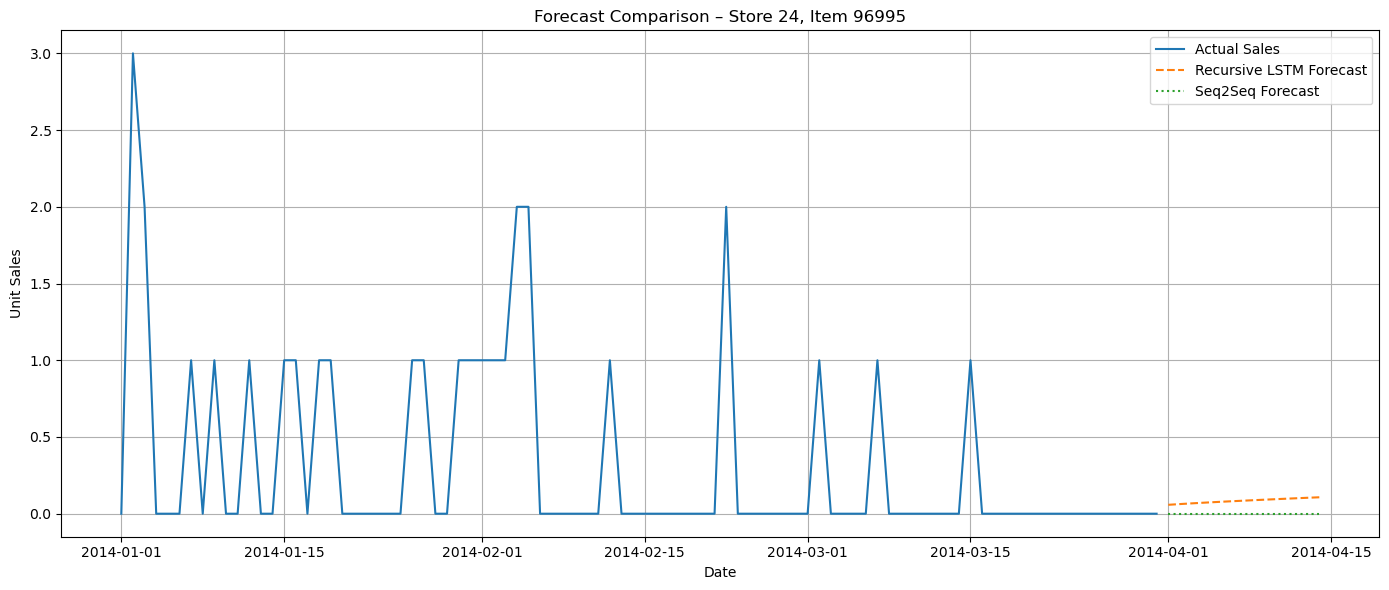

In [46]:
# --- COMPARISON PLOT: One-Step LSTM vs. Seq2Seq Forecast ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

# --- Load data and scaler ---
if df.index.name == "date":
    df = df.reset_index()

df = df.sort_values("date").copy()
df = df.set_index("date")
df = df[["unit_sales"]].copy()
df["unit_sales"] = df["unit_sales"].astype(float)

# Normalize
scaler_lstm = joblib.load(f"scaler_store{store_id}_item{item_id}.pkl")
df["scaled"] = scaler_lstm.transform(df[["unit_sales"]])

n_steps = 14
forecast_horizon = 14

# --- One-step recursive LSTM forecast ---
lstm_model = load_model(f"lstm_model_store{store_id}_item{item_id}.keras")
last_seq = df["scaled"].values[-n_steps:]
lstm_input = last_seq.reshape(1, n_steps, 1)
recursive_preds = []
for _ in range(forecast_horizon):
    next_pred = lstm_model.predict(lstm_input, verbose=0)[0, 0]
    recursive_preds.append(next_pred)
    lstm_input = np.append(lstm_input[:, 1:, :], [[[next_pred]]], axis=1)
recursive_forecast = scaler_lstm.inverse_transform(np.array(recursive_preds).reshape(-1, 1)).flatten()

# --- Seq2Seq forecast ---
scaler_seq2seq = joblib.load(f"scaler_seq2seq_store{store_id}_item{item_id}.pkl")
seq2seq_model = load_model(f"lstm_seq2seq_store{store_id}_item{item_id}.keras")

# Prepare encoder input
seq = df["scaled"].values[-n_steps:]
encoder_input = seq.reshape(1, n_steps, 1)
decoder_input = np.zeros((1, forecast_horizon, 1))
seq2seq_scaled_pred = seq2seq_model.predict([encoder_input, decoder_input], verbose=0)[0, :, 0]
seq2seq_forecast = scaler_seq2seq.inverse_transform(seq2seq_scaled_pred.reshape(-1, 1)).flatten()

# --- Plot forecast comparison ---
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

plt.figure(figsize=(14, 6))
plt.plot(df.index[-90:], df["unit_sales"].iloc[-90:], label="Actual Sales")
plt.plot(forecast_dates, recursive_forecast, label="Recursive LSTM Forecast", linestyle="--")
plt.plot(forecast_dates, seq2seq_forecast, label="Seq2Seq Forecast", linestyle=":")
plt.title(f"Forecast Comparison – Store {store_id}, Item {item_id}")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
